# Case Study - Fraud Detection

### Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
def read_data():
    #Read data & Change the data type of columns to match the data.Some of the variables though represented by data are actually boolean.
    #For example used_chip is boolean but represented by number in the dataset. Similarly for repeat_retailer, used_pin_number, online_order, fraud
    data = pd.read_csv('card_transdata.csv',sep = ',', float_precision='high')
    data.columns = data.columns.str.strip().str.lower().str.replace(' ','_').str.replace('/','_')
    data.distance_from_home = data.distance_from_home.apply('float64')
    data.distance_from_last_transaction = data.distance_from_last_transaction.apply('float64')
    data.ratio_to_median_purchase_price = data.ratio_to_median_purchase_price.apply('float64')
    data.repeat_retailer = data.repeat_retailer.astype(bool)
    data.used_chip = data.used_chip.astype(bool)
    data.used_pin_number = data.used_pin_number.astype(bool)
    data.online_order = data.online_order.astype(bool)
    data.fraud = data.fraud.astype(bool)
    return data

In [3]:
data = read_data()
# Calculate min, max, mean, standard deviation IQR 1, 2, 3
data.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price
count,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182
std,65.390784,25.843093,2.799589
min,0.004874,0.000118,0.004399
25%,3.878008,0.296671,0.475673
50%,9.967760,0.998650,0.997717
75%,25.743985,3.355748,2.096370
max,10632.723672,11851.104565,267.802942


In [4]:
# (Rows,Columns)
data.shape

(1000000, 8)

- There are total 1000000 observations in the dataset with 8 variables. 
- The target variable is `fraud`

In [5]:
# Samples of Data
data.sample(5)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
935552,26.386842,0.422674,1.898303,True,True,False,True,False
367537,21.983305,6.189719,1.358906,True,False,False,True,False
698714,32.104972,3.626442,1.046042,True,False,False,True,False
490275,10.367621,7.358678,2.572531,True,True,False,True,False
125021,33.134090,0.756146,1.368496,True,True,False,True,False


In [6]:
data.groupby("repeat_retailer")["fraud"].describe()

,count,unique,top,freq
repeat_retailer,,,,
False,118464,2,False,107986
True,881536,2,False,804611


In [7]:
data.groupby("used_pin_number")["fraud"].describe()

,count,unique,top,freq
used_pin_number,,,,
False,899392,2,False,812262
True,100608,2,False,100335


In [8]:
data.groupby("online_order")["fraud"].describe()

,count,unique,top,freq
online_order,,,,
False,349448,2,False,344756
True,650552,2,False,567841


In [9]:
data.groupby("fraud")["distance_from_home"].describe()

,count,mean,std,min,25%,50%,75%,max
fraud,,,,,,,,
False,912597.0,22.832976,52.828655,0.004874,3.828942,9.673847,24.158057,8777.136420
True,87403.0,66.261876,134.391608,0.025847,4.585729,15.454219,101.110104,10632.723672


## Exploratory Data Analysis

### Check for Missing Values

Check for the missing values present in the dataset. If there are any, need to handle those with different techniques.

In [10]:
pd.DataFrame(data.isna().sum())

,0
distance_from_home,0
distance_from_last_transaction,0
ratio_to_median_purchase_price,0
repeat_retailer,0
used_chip,0
used_pin_number,0
online_order,0
fraud,0


#### As seen above dataset doesnt contain any missing values so no need to treat the missing values

## Preporcess the Data

In [11]:
#Lets create lists so that we can identify and analyze numerical and binary features differently

binary_features = data.columns[data.dtypes == 'bool']
target = 'fraud'
binary_features = binary_features[binary_features != target]
numeric_features = data.columns[(data.dtypes == 'int64') | (data.dtypes == 'float64')]
numeric_features = numeric_features[numeric_features != target]

#### Numeric Features

In [12]:
pd.DataFrame(numeric_features)

,0
0,distance_from_home
1,distance_from_last_transaction
2,ratio_to_median_purchase_price


#### Binary Features

In [13]:
pd.DataFrame(binary_features)

,0
0,repeat_retailer
1,used_chip
2,used_pin_number
3,online_order


### Correlation With Target

Identify the features which have correlation with the target feature. It will give us understanding of the features which have direct impact on the target and would be considered for model training.

#### Pearson Correlation Of Numeric Features Against Target

In [14]:
# We are considering `fraud` as target feature
target = 'fraud'
corr_with_target = data.corr(method ='pearson').loc[target]
corr_with_target = corr_with_target.loc[corr_with_target.index != target]

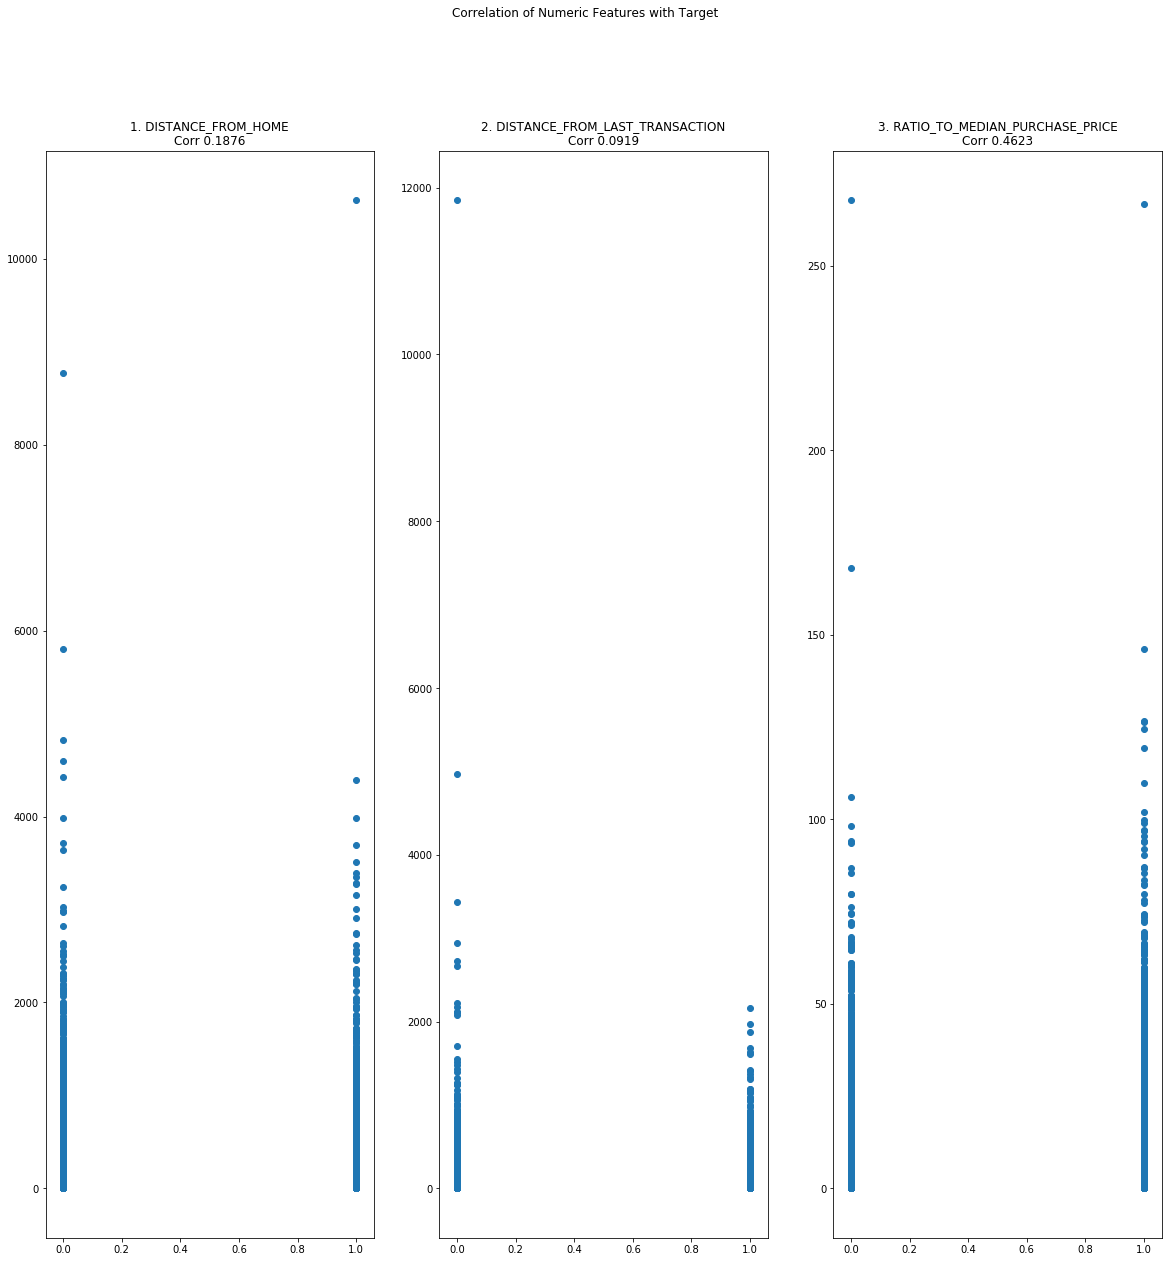

In [15]:
t = len(numeric_features)
n = 3
m = int(np.ceil(t/n))

fig, axarr = plt.subplots(m,n)
fig.set_size_inches(20, 20)
fig.subplots_adjust(hspace=0.3)
fig.suptitle('Correlation of Numeric Features with Target')
for i, ax in enumerate(axarr):
    col = numeric_features[i]
    ax.set_title('{}. {}\nCorr {}'.format(i+1,col.upper(),round(corr_with_target[col],4)))
    ax.scatter(data[target], data[col].values)
#use seaborn here Categorical


#### Observations
- None of the features have significant correlation with target so we cant use linear regression to solve this problem

### ANOVA of Binary Features Against Target
The ANOVA test assesses whether the averages of more than two groups are statistically different from each other. This analysis is appropriate for comparing the averages of a numerical variable for more than two categories of a categorical variable.

If the pvalue calculated by f-test is very small, we can reject the null hypothesis that there isn't any significance difference between the averages of groups. And particular feature would be more significant from model building perspective.

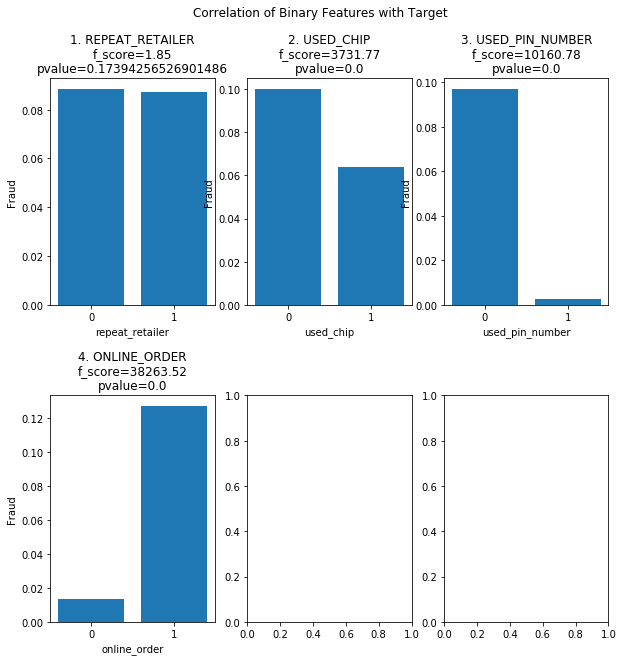

In [16]:
t = len(binary_features)
n = 3
m = int(np.ceil(t/n))

fig, axarr = plt.subplots(m,n)
fig.set_size_inches(10, 10)
fig.subplots_adjust(hspace=0.4)
fig.suptitle('Correlation of Binary Features with Target')
axlist = list(chain.from_iterable((axarr)))
for i in range(t):
    ax = axlist[i]
    col = binary_features[i]
    ax.set_title('{}'.format(col))
    freq = data[[col,target]].groupby(col).mean()
    if (not(freq.index.isin(['True']).any())):
        freq.index = freq.index.values.astype(int)
    freq = freq.sort_index()
    freq.index = freq.index.astype(str)
    ax.bar(freq.index.values,freq.values.ravel())
    
    feat_selector = SelectKBest(f_classif, k=1)
    _ = feat_selector.fit((data[target].values).reshape(-1,1),(data[col].values).ravel())
    
    title = '{}. {}\nf_score={}\npvalue={}'.format(i+1,col.upper(),round(feat_selector.scores_[0],2),feat_selector.pvalues_[0])
    ax.set_title(title)
    ax.set_ylabel('Fraud')
    ax.set_xlabel(col)
    

#### Observations
- P-value ≤ 0.05 : The differences between some of the means are statistically significant
- P-value > 0.05 : The differences between the means are not statistically significant
- `REPEAT_RETAILER` is significant feature as its value is way more then 0.05
- All other features besides `repeat_retailer` are correlated.

## Correlated Features
We consider some threshold to conclude that two features are strongly correlated. We have considered absoulate correlation should have coefficient beyond 0.7 to have strong relationship.

### Visualize Correlation Matrix

In [17]:
numeric_features

data[numeric_features].corr()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price
distance_from_home,1.000000,0.000193,-0.001374
distance_from_last_transaction,0.000193,1.000000,0.001013
ratio_to_median_purchase_price,-0.001374,0.001013,1.000000


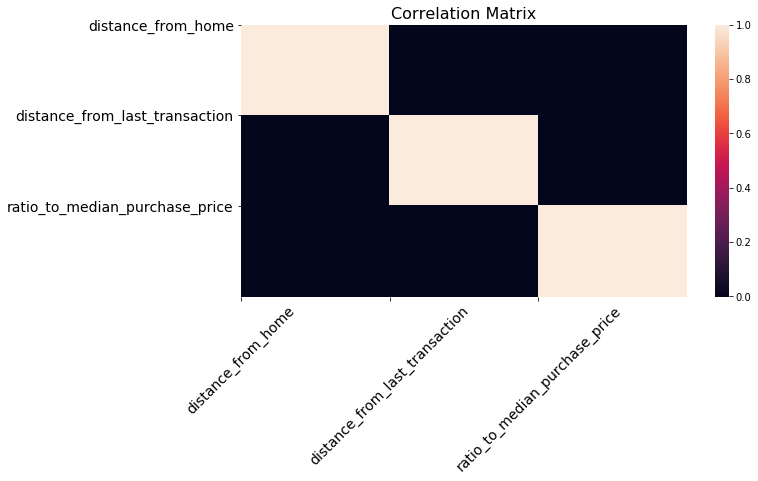

In [18]:
f = plt.figure(figsize=(10, 5))
sb.heatmap(data[numeric_features].corr())
plt.xticks(range(data[numeric_features].shape[1]), data[numeric_features].columns, fontsize=14, rotation=45)
plt.yticks(range(data[numeric_features].shape[1]), data[numeric_features].columns, fontsize=14)
plt.title('Correlation Matrix', fontsize=16);

### Correlation Threshold

In [19]:
corr_threshold = 0.7
corr_features = data.corr(method ='pearson').apply(lambda x: x[abs(x) > corr_threshold].index[x[abs(x) > corr_threshold].index != x.name].values ,axis =1)
pd.DataFrame(corr_features)

,0
distance_from_home,[]
distance_from_last_transaction,[]
ratio_to_median_purchase_price,[]
repeat_retailer,[]
used_chip,[]
used_pin_number,[]
online_order,[]
fraud,[]


## Train the Model
### Desicision Tree Classifier

In [20]:
RSEED = 50

# Load in data
df = read_data()
# Extract the labels
labels = np.array(df.pop('fraud'))

In [21]:
from sklearn.model_selection import train_test_split
# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

In [22]:
# Features for feature importances
features = list(train.columns)
# features.remove('online_order')
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=RSEED, max_depth=3, min_samples_leaf=10000)
# Train tree
tree.fit(train, train_labels)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 15 nodes with maximum depth 3.


In [23]:
# Make probability predictions
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)

In [24]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(train_labels, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_labels, probs)}')

Train ROC AUC Score: 0.991085198431768
Test ROC AUC  Score: 0.9908969147658236


In [25]:
estimator = tree
# Export a tree from the forest
export_graphviz(estimator, 'tree_from_optimized_forest.dot', rounded = True, 
                feature_names=train.columns, max_depth = 8, 
                class_names = ['poverty', 'no poverty'], filled = True)
print(f'Baseline ROC AUC: {roc_auc_score(test_labels, [1 for _ in range(len(test_labels))])}')

Baseline ROC AUC: 0.5


In [26]:
train.shape

(700000, 7)

In [27]:
test.shape

(300000, 7)

Our model does outperform a baseline guess, but we can see it has severely overfit to the training data, acheiving perfect ROC AUC.

In [28]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [29]:
from collections import Counter
print(Counter(probs))
print(Counter(predictions))

Counter({0.0: 251331, 0.9001030704133666: 15851, 0.5913366336633663: 8852, 0.0858831936594556: 6495, 0.013726024906826652: 4625, 0.1842: 4302, 0.357: 4297, 0.9165166966606678: 4247})
Counter({False: 271050, True: 28950})


Recall Baseline: 1.0 Test: 0.89 Train: 0.89
Precision Baseline: 0.09 Test: 0.81 Train: 0.81
Roc Baseline: 0.5 Test: 0.99 Train: 0.99


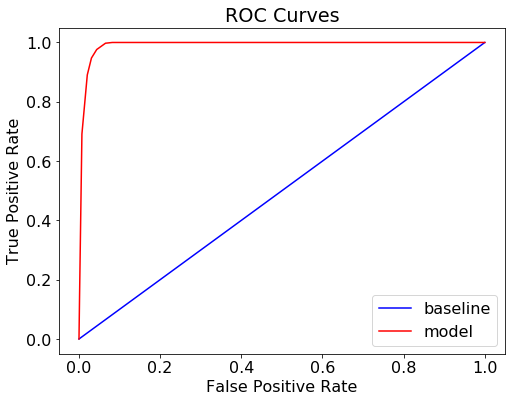

In [30]:
evaluate_model(predictions, probs, train_predictions, train_probs)

In [31]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[268181   5598]
 [  2869  23352]]


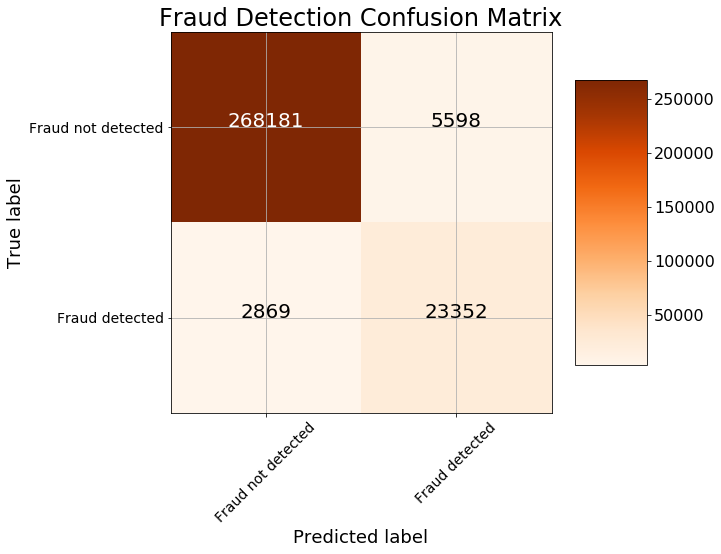

In [32]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes = ['Fraud not detected', 'Fraud detected'],
                      title = 'Fraud Detection Confusion Matrix')

This shows the classifications predicted by the model on the test data along with the real labels. We can see that our model has many false negatives (predicted fraud detected but actually it is not a fraud case) and false positives (detected not fraud but actually a case of fraud).

Although the ROC Curve is a helpful diagnostic tool, it can be challenging to compare two or more classifiers based on their curves.

Instead, the area under the curve can be calculated to give a single score for a classifier model across all threshold values.

### precision-recall auc for a predictive model

In [33]:

from sklearn.datasets import make_classification
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

model = DecisionTreeClassifier(random_state=RSEED, max_depth=5, min_samples_leaf=10000)
model.fit(train, train_labels)
yhat = model.predict_proba(test)
pos_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(test_labels, pos_probs)
auc_score_test = auc(recall, precision)

# calculate the precision-recall for train model
yhat_train = model.predict_proba(train)
pos_probs_train = yhat_train[:, 1]
precision_train, recall_train, _ = precision_recall_curve(train_labels, pos_probs_train)
auc_score_train = auc(recall_train, precision_train)

print('Test Precision Recall AUC: %.3f' % auc_score_test)
print('Train Precision Recall AUC: %.3f' % auc_score_train)

Test Precision Recall AUC: 0.880
Train Precision Recall AUC: 0.886


In [34]:
from sklearn.metrics import f1_score
print(f1_score(train_labels,[1 if  p > 0.5 else 0 for p in yhat_train[:, 1]]))
print(f1_score(test_labels,[1 if  p > 0.5 else 0 for p in yhat[:, 1]]))

0.8467236378380065
0.846531692374617


Confusion matrix, without normalization
[[268181   5598]
 [  2869  23352]]


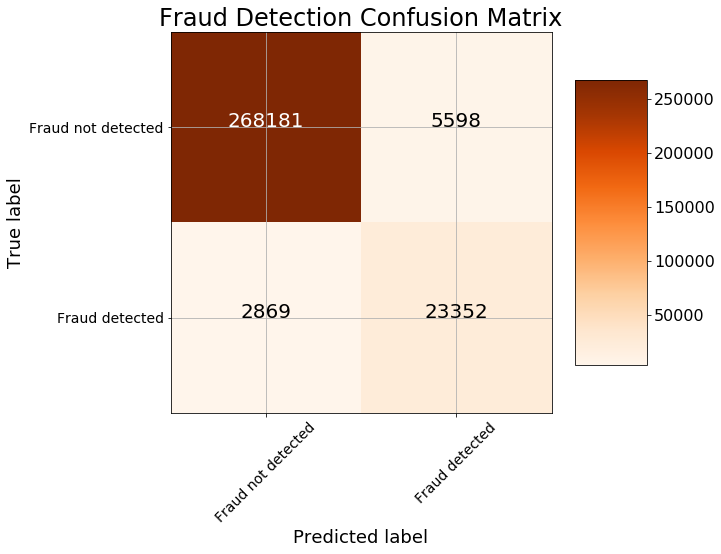

In [35]:
cm = confusion_matrix(test_labels, [1 if  p > 0.5 else 0 for p in yhat[:, 1]])
plot_confusion_matrix(cm, classes = ['Fraud not detected', 'Fraud detected'],
                      title = 'Fraud Detection Confusion Matrix')

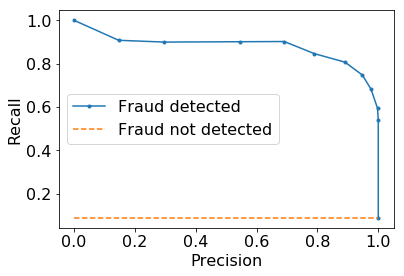

In [36]:
fraud_PR = len(test_labels[test_labels==1]) / len(test_labels)
plt.plot(recall, precision, marker='.', label='Fraud detected')
plt.plot([0, 1], [fraud_PR, fraud_PR], linestyle='--', label='Fraud not detected')
# axis labels
plt.ylabel('Recall')
plt.xlabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [37]:
fi = pd.DataFrame({'feature': features,
                   'importance': tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi

,feature,importance
2,ratio_to_median_purchase_price,0.568412
6,online_order,0.296545
0,distance_from_home,0.105005
1,distance_from_last_transaction,0.030039
3,repeat_retailer,0.000000
4,used_chip,0.000000
5,used_pin_number,0.000000


## Random Forest 

Now we can move on to a more powerful model, the random forest. This takes the idea of a single decision tree, and creates an _ensemble_ model out of hundreds or thousands of trees to reduce the variance. Each tree is trained on a random set of the observations, and for each split of a node, only a subset of the features are used for making a split. When making predictions, the random forest averages the predictions for each of the individual decision trees for each data point in order to arrive at a final classification.

Creating and training a random forest in extremely easy in Scikit-Learn. The cell below is all you need.

In [38]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=50, verbose=1, warm_start=False)

In [39]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 411
Average maximum depth 19


We see that each decision tree in the forest has many nodes and is extremely deep. However, even though each individual decision tree may overfit to a particular subset of the training data, the idea is that the overall random forest should have a reduced variance.

## Random Forest Results

In [40]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.0s finished


Recall Baseline: 1.0 Test: 1.0 Train: 1.0
Precision Baseline: 0.09 Test: 1.0 Train: 1.0
Roc Baseline: 0.5 Test: 1.0 Train: 1.0


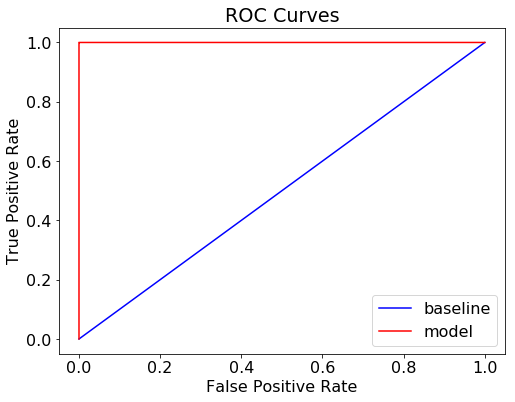

In [41]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

Confusion matrix, without normalization
[[273779      0]
 [     3  26218]]


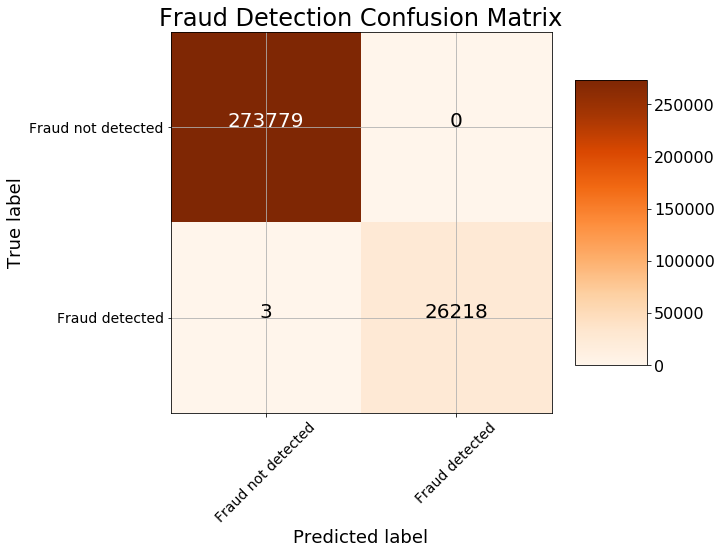

In [42]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Fraud not detected', 'Fraud detected'],
                      title = 'Fraud Detection Confusion Matrix')

### Random forest same plot

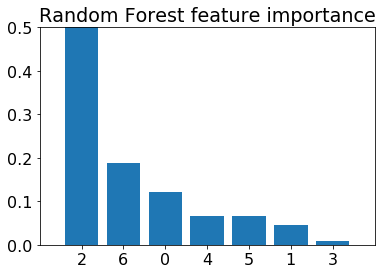

In [43]:
std = np.std([model.feature_importances_ for tree in model.estimators_],
             axis=0)
importance_vals = model.feature_importances_
indices = np.argsort(importance_vals)[::-1]
importance_vals
# Plot the feature importances of the forest
plt.figure()
plt.title("Random Forest feature importance")
plt.bar(range(train.shape[1]), importance_vals[indices],
        yerr=std[indices], align="center")
plt.xticks(range(train.shape[1]), indices)
plt.xlim([-1, train.shape[1]])
plt.ylim([0, 0.5])
plt.show()

In [44]:
for idx, val in enumerate(features):
    print("{} => {}".format(idx, val))

0 => distance_from_home
1 => distance_from_last_transaction
2 => ratio_to_median_purchase_price
3 => repeat_retailer
4 => used_chip
5 => used_pin_number
6 => online_order


## Observations
- Most relevant feature is at index 2 i.e., `ratio_to_median_purchase_price`. <br>Similarly, we can derive -

- Second relevant feature is `online_order`
- Least relevant feature is `repeat_retailer`

### Ways of improving the model

An ensemble for classification is a composite model, made up of
a combination of classifiers. 
The individual classifiers vote, and a class label prediction
is returned by the ensemble based on the collection of votes. 
Ensembles tend to be more accurate than their component classifiers. 


- random forests is example of ensemble method since it tends to be more accurate than its base classifiers.
- First we tried with `Descision Tree classifier` and then implemented `Random Forest Algorithm` on same data set for better accuracy of Fraud Detection


